# Bayesian Data Analysis

1. Parameter Estimation (model parameters like rationality/optimality parameter)
2. Model Criticism (can the model explain the data)
3. Model Comparison (relative evidence of models given data)

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

def normalize(x, axis):
    return x / x.sum(axis=axis, keepdims=True)

In [2]:
objects = ["blue square", "blue circle", "green square"]
utterances = ["blue", "green", "square", "circle"]

def meaning(u, o):
    return float(u in o)
def denotation(u, s):
    return np.array([meaning(u, o) for o in s])

us = np.array([denotation(utr, objects) for utr in utterances])

l0 = normalize(us, 1)
pd.DataFrame(l0, columns=objects, index=utterances)

,blue square,blue circle,green square
blue,0.5,0.5,0.0
green,0.0,0.0,1.0
square,0.5,0.0,0.5
circle,0.0,1.0,0.0


Previously we did not use any cost or non-uniform state prior. Below the vanilla RSA is updated to accomodate these terms.

In [3]:
def vanilla_rsa(tau_S, l0, cost_vec, state_prior):
    """Vanilla RSA with 1 iteration over literals: a speaker and a pragmatic listener.
    Args:
    - tau_S: speaker's rationality (optimality)
    - l0: denotation mapping
    - cost_vec: vector of cost values for each utterance
    - state_prior: prior probability of states (objects), a vector of probabilities

    Returns:
    idata with prior predictives on two categorical distributions
    - S1: speaker
    - L1: pragmatic listener
    """
    with pm.Model() as m_RSA:
        
        # P_S1(u|P_L0)
        S1 = pm.Deterministic(
            'S1',
            normalize(
                pt.exp(
                    tau_S * (
                        pt.log(l0) - cost_vec
                    )                    
                ),
                0
            )
        )

        L1 = pm.Deterministic(
            'L1',
            normalize(
                S1 * state_prior,
                1
            )
        )
        
        pm.Categorical('pL1',
                        p=L1)
        
        idata = pm.sample_prior_predictive()
    
        return idata

In [4]:
def RSA_pTables(alpha, l0, cost_vec, state_prior):
    idata = vanilla_rsa(alpha, l0, cost_vec, state_prior)
    # literal listener
    print("L0")
    print(pd.DataFrame(l0, columns=objects, index=utterances))
    # speaker
    S1_ = idata.prior.S1.stack(samples=("chain", "draw")).mean(axis=2).T.values
    print("S1")
    print(pd.DataFrame(S1_, columns=utterances, index=objects))
    # pragmatic listener
    L1_ = idata.prior.L1.stack(samples=("chain", "draw")).mean(axis=2)
    print("L1")
    print(pd.DataFrame(L1_, columns=objects, index=utterances))

In [5]:
RSA_pTables(1, l0, 0, np.array([1, 1, 1]))

Sampling: [pL1]


L0
        blue square  blue circle  green square
blue            0.5          0.5           0.0
green           0.0          0.0           1.0
square          0.5          0.0           0.5
circle          0.0          1.0           0.0
S1
                  blue     green    square    circle
blue square   0.500000  0.000000  0.500000  0.000000
blue circle   0.333333  0.000000  0.000000  0.666667
green square  0.000000  0.666667  0.333333  0.000000
L1
        blue square  blue circle  green square
blue            0.6          0.4           0.0
green           0.0          0.0           1.0
square          0.6          0.0           0.4
circle          0.0          1.0           0.0


In [6]:
blue_listener = {
    "blue circle": 65,
    "green square": 0,
    "blue square": 115
    }   

Data interpretation:
- is 115 in 180 (115+65) surprising under a null hypothesis?
- null = literal listener: blue circle and blue square are equally likely

In [7]:
from scipy.stats import binomtest, binom

binomtest(115, 115+65, p=0.5, alternative="greater")

BinomTestResult(k=115, n=180, alternative='greater', statistic=0.6388888888888888, pvalue=0.00011953843135813762)

This shows that it's highly unlikely that the data is from a literal listener.

We can also do a Bayesian data analysis:
- first we assume that two models are to be compared: the literal listener model ($M_{L_0}$) and the pragmatic listener model ($M_{L_1}$)
- we don't have a prior preference so $P(M_{L_0}) = P(M_{L_1}) = 0.5$
- we observed data $D$

the Bayes rule gives:
$$ P(M_{L_0} \mid D) = \frac{ P(M_{L_0}) \cdot P(D \mid M_{L_0})}{P(M_{L_0}) \cdot P(D \mid M_{L_0})  +  P(M_{L_1}) \cdot P(D \mid M_{L_1})} $$

and since $P(M_{L_0}) = P(M_{L_1}) = 0.5$:
$$ P(M_{L_0} \mid D) = \frac{P(D \mid M_{L_0}) }{P(D \mid M_{L_0}) + P(D \mid M_{L_1}) } $$

- now we need to put likelihood values in the equations. likelihoods are binomial distributions, because the variable is binary.

In [8]:
total_observation = 180
observed_success = 115
L0_likelihood = binom.pmf(observed_success, total_observation, 0.5)
L1_likelihood = binom.pmf(observed_success, total_observation, 0.6)
p_L0_D = L0_likelihood / (L0_likelihood + L1_likelihood)
p_L0_D

0.0015582254509732545

Exercises:
- $P(M_{L_1} | D)$

In [9]:
p_L1_D = L1_likelihood / (L0_likelihood + L1_likelihood)
p_L1_D

0.9984417745490267

In [10]:
# or
1 - p_L0_D

0.9984417745490267

- How much more likely is the pragmatic listener than the literal listener model, given data?

In [11]:
p_L1_D / p_L0_D

640.7556582556192

- What we should've observed to make literal listener model more likely?
- How the number of observations affect the posterior, keeping the success rate the same?

/var/folders/_x/c00gpvvj08144m_76ng172dh0000gn/T/ipykernel_37210/3797628661.py:24: RuntimeWarning: invalid value encountered in divide
  p_L0_D = L0_likelihood / (L0_likelihood + L1_likelihood)


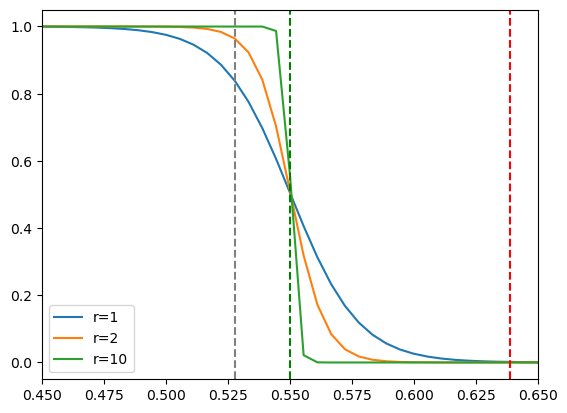

In [12]:
multiplier = [1, 2, 10]
possible_successes = np.arange(181)
L0_likelihood = np.array(
    [
        [
            binom.pmf(
                observed_success * mult,
                total_observation * mult,
                0.5) 
            for observed_success in possible_successes] 
        for mult in multiplier]
    )
L1_likelihood = np.array(
    [
        [
            binom.pmf(
                observed_success * mult,
                total_observation * mult,
                0.6) 
            for observed_success in possible_successes] 
        for mult in multiplier]
    )

p_L0_D = L0_likelihood / (L0_likelihood + L1_likelihood)
success_ratio = possible_successes / 180
for i in range(3):
    plt.plot(success_ratio, p_L0_D[i,:])
plt.axvline(x=115/180, c='r', linestyle="--")
plt.axvline(x=possible_successes[np.abs(p_L0_D[0,:]-0.5).argmin()]/180,
            c='g', linestyle="--")
plt.axvline(x=95/180, c='grey', linestyle='--')
plt.xlim([0.45, 0.65])
plt.legend(["r=1", "r=2", "r=10"]);

- The red line is for 115 successes; and the green line is at 0.5 posterior probability for literal listener model. It occurs at 99 successes, so any observation below 99 successes would make the literal listener model more likely.
- For multiplier values 1, 2, and 10 we get steeper slopes around the 0.5 probability point. Now x-axis is actually the ratio between success and total. For 115/180 ratio, but different scales we get lower porbabilities for literal listener, as the scale gets larger. Similarly, for the 100/180 ratio the posterior favors the literal listener less, when the scale is small.

In [13]:
print(99/180)
print(p_L0_D[0,115])
print(p_L0_D[1,115])
print(p_L0_D[2,115])
print("----------------")
print(p_L0_D[0,95])
print(p_L0_D[1,95])
print(p_L0_D[2,95])

0.55
0.0015582254509732545
2.4356452972263695e-06
8.571868509995541e-29
----------------
0.8384383114535411
0.9641985185805302
0.999999929421462


### Parameter Estimation

Consider the RSA model as a function of alpha. Following tables show the listener probabilities as $\alpha \rightarrow 0$.

Note that as $\alpha$ gets smaller the pragmatic listener gets closer to literal listener. So, we can think of literal listener as a special case of the pragmatic one. But at $\alpha=0$ the literal listener is simply multiplied with zeros, leading to vector of ones for each state after exponentiating. Normalizing them for four utterances gives a probability of 0.25 to each, which is an artifact.

Also note that as $\alpha \rightarrow \infty$ (and actually for small numbers too) the inference works as maximum utility.

In [14]:
# change alpha to see other results
RSA_pTables(1, l0, 0, np.array([1, 1, 1]))

Sampling: [pL1]


L0
        blue square  blue circle  green square
blue            0.5          0.5           0.0
green           0.0          0.0           1.0
square          0.5          0.0           0.5
circle          0.0          1.0           0.0
S1
                  blue     green    square    circle
blue square   0.500000  0.000000  0.500000  0.000000
blue circle   0.333333  0.000000  0.000000  0.666667
green square  0.000000  0.666667  0.333333  0.000000
L1
        blue square  blue circle  green square
blue            0.6          0.4           0.0
green           0.0          0.0           1.0
square          0.6          0.0           0.4
circle          0.0          1.0           0.0


- It's like having many models, for each value of $\alpha$.
- Or we can say that we have a parameterized likelihood function for observational data $P(D|M_{L_1}, \alpha)$
- $\alpha$ is continuous, and the model is fixed, so we can drop its term. 
- For a general data-parameter relationship we can estimate parameters from data as follows:
$$P(\theta \mid D) = \frac{P(\theta) \cdot P(D \mid \theta)}{ \int P(\theta') \cdot P(D \mid \theta') \ \text{ d} \theta'}$$

- The problem with calculation of the above expression comes from the marginal likelihood term.
- That normalizing constant (i.e. the integral term), when the parameter space is complex and contains continuous variables, is hard to compute, generally without an analytical solution.
- We can use MCMC to get samples from $P(\theta|D)$ by using the non-normalized posterior scores: $P(\theta) \cdot P(D \mid \theta)$. This is the likelihood and prior probability multiplied.
- We'll use `pymc` to approximate the posterior with sampling. What we need is a definition of how non-normalized posterior scores are generated, in `pymc` terms.

In [15]:
with pm.Model() as m_RSA:

    # L0 as data
    L0 = pm.Data(
        'L0',
        l0,
        dims=('u', 's')
    )

    # prior for alpha
    # >= 0 
    alpha = pm.Uniform(
        'alpha',
        lower=0.1,
        upper=10
    )

    # alpha = pm.Gamma(
    #     'alpha',
    #     alpha=0.1,
    #     beta=0.1
    # )

    # simplify cost
    cost_vec = 0

    # P_S1(u|P_L0)
    S1 = pm.Deterministic(
        'S1',
        normalize(
            np.exp(
                alpha * np.log(L0+0.001) # TODO: handle special cases for likelihoods (e.g. alpha=0 and log(0))
            ),
            0
        )
    )

    L1 = pm.Deterministic(
        'L1',
        normalize(
            S1,
            1
        )
    )

    # data is for u="blue"
    # we need the probability of interpreting the "blue square"
    
    pm.Binomial('pL1', n=180, p=L1[0,0], observed=115)
    # pm.Binomial('pL1', n=1800, p=L1[0,0], observed=1150)
    # pm.Binomial('pL1', n=18000, p=L1[0,0], observed=11500)



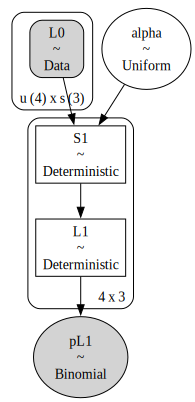

In [16]:
pm.model_to_graphviz(m_RSA)

In [17]:
with m_RSA:
    idata = pm.sample(draws=10_000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Output()

Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 4 seconds.


<Axes: title={'center': 'alpha'}>

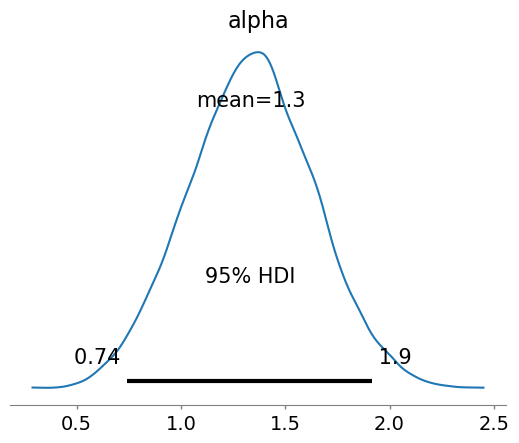

In [18]:
az.plot_posterior(idata, var_names=['alpha'], hdi_prob=0.95)

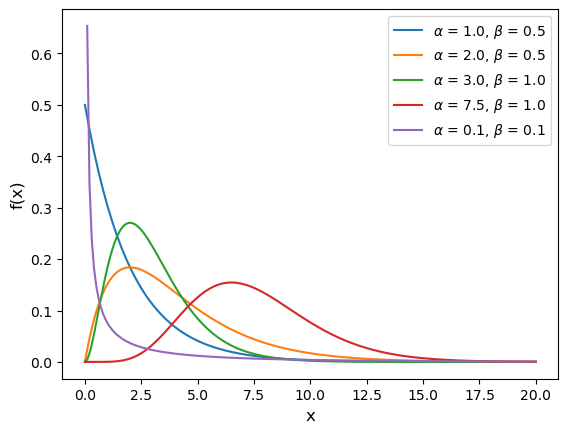

In [19]:
from scipy.stats import gamma
x = np.linspace(0, 20, 200)
alphas = [1., 2., 3., 7.5, .1]
betas = [.5, .5, 1., 1., .1]
for a, b in zip(alphas, betas):
    pdf = gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

Exercises:
- Posterior $\alpha$ is distributed around a mean of 1.3
- Probability of having $\alpha=1$ is much larger than probability of $\alpha=0$. Both are less probable than $\alpha=1.3$ given this dataset.
- A Gamma distribution (with parameters $\alpha=1$ and $\beta=0.1$) assigns smaller probability to larger values of alpha. But there seems to be no difference in the posterior distributions, compared to the one we get with the uniform prior. Maybe we can note that the lower bound of the HDI gets smaller with the Gamma prior. Using parameters $\alpha=7.5$ and $\beta=1$ makes a slight change in expected $\alpha$ value towards larger values.
- Keeping the success ratio the same, more observations should make inference more certain of a particular parameter value. You can see this effect if you simply multiply `n` and `observed` in `Binomial` term with multiples of 10. Note that the 95%HDI gets smaller and smaller.

In [20]:
salience_priors = {
  "blue_circle":   71,  # object "blue circle" was selected 71 times
  "green_square": 139,
  "blue_square":   30,
}

prod_data = {
  "blue_circle":  {"blue":  9, "circle": 135, "green":   0, "square":  0},
  "green_square": {"blue":  0, "circle":   0, "green": 119, "square": 25},
  "blue_square":  {"blue": 63, "circle":   0, "green":   0, "square": 81}
}

comp_data = {
  "blue":   {"blue_circle": 65, "green_square":   0, "blue_square": 115},
  "square": {"blue_circle":  1, "green_square": 117, "blue_square":  62}
}

In [21]:
def dict_dict_array(data):
    """Converts a dictionary of dictionaries to a numpy array."""

    rows = list(data.keys())
    cols = list(data[rows[0]].keys())
    return np.array([[data[row][col] for col in cols] for row in rows])

In [22]:
dict_dict_array(prod_data)

array([[  9, 135,   0,   0],
       [  0,   0, 119,  25],
       [ 63,   0,   0,  81]])

- Participants found the green square to be the most salient object, without hearing any utterance. This may be due to the unique color. The unique shape was the second most salient object.
- Now we need to incorporate this knowledge into the state priors for $L_0$ inference. To do this we need to use these count data for prior probabilities of objects in $P(s)$. We previously computed the denotation values, now we have to use counts to change probabilities.

$$P_{L_{0}}(s\mid u) \propto [\![u]\!](s) \cdot P(s)$$

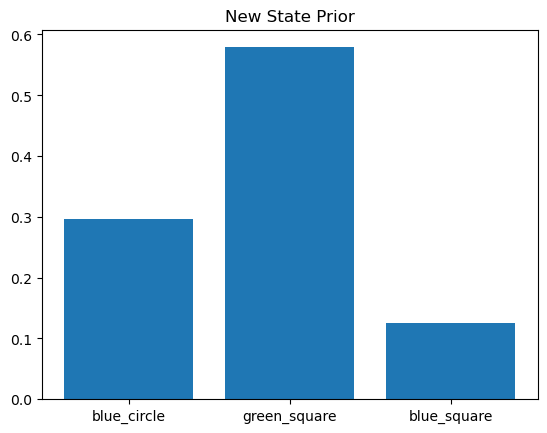

In [23]:
plt.bar(
    salience_priors.keys(), np.array(list(salience_priors.values())) / sum(salience_priors.values())
)
plt.title("New State Prior");

In [24]:
state_prior = np.array(
    (
        salience_priors["blue_square"],
        salience_priors["blue_circle"],
        salience_priors["green_square"],
    )
) / sum(salience_priors.values())
state_prior

array([0.125     , 0.29583333, 0.57916667])

In [25]:
l0_2 = normalize(
    us * state_prior,
    1,
)
pd.DataFrame(l0_2, columns=objects, index=utterances)

,blue square,blue circle,green square
blue,0.297030,0.70297,0.000000
green,0.000000,0.00000,1.000000
square,0.177515,0.00000,0.822485
circle,0.000000,1.00000,0.000000


In [26]:
# compare with
pd.DataFrame(l0, columns=objects, index=utterances)

,blue square,blue circle,green square
blue,0.5,0.5,0.0
green,0.0,0.0,1.0
square,0.5,0.0,0.5
circle,0.0,1.0,0.0


With this new prior, we have a different distribution for $P_{L_0}(s|u)$:
- the binary denotation function is still effective: we see that only logically possible inferences are possible
- the remaining probability mass is distributed according to the prior mass: e.g. the blue square and blue circle for utterance blue is proportional to the prior beliefs now; similarly the blue square is very less likely compared to the green square, when square is uttered

The comprehension (listener) and production (speaker) datasets:
- The production data suggests that speakers tend to choose the unique (or more informative) property of the referent. (e.g. they tend to use circle rather than blue to refer to the blue_circle)
- The experiment tests for non-unique feature values in comprehension task, i.e. shared color (blue) and shape (square) is tested. It is also interesting to see that the color term comprehension follows RSA model predictions (participants favor blue square) but the shape term does not (participants favor green square)
- For "blue_square" they tend to select the shape term, i.e. square rather than blue. This sort of tendency can be reflected in a cost function by assigning a higher cost to color utterances.
- Below we define a cost function which assigns zero cost to shape features, and a cost $c$ to color feature utterances. Now we introduce another free parameter, the cost.

In [27]:
def cost_f(u, c):
    if u in ["blue", "green"]:
        return c
    else:
        return 0

print(cost_f("blue", 3))
print(cost_f("circle", 3))

3
0


In [28]:
# assume different c values
c = 1
[cost_f(u, c) for u in utterances]

[1, 1, 0, 0]

In [29]:
# results with c=0, alpha=1
RSA_pTables(1, #alpha
            l0_2, # L0 with new state prior
            np.array([cost_f(u, 0) for u in utterances]).reshape(4, 1),
            state_prior=state_prior)

Sampling: [pL1]


L0
        blue square  blue circle  green square
blue       0.297030      0.70297      0.000000
green      0.000000      0.00000      1.000000
square     0.177515      0.00000      0.822485
circle     0.000000      1.00000      0.000000
S1
                  blue     green    square    circle
blue square   0.625926  0.000000  0.374074  0.000000
blue circle   0.412791  0.000000  0.000000  0.587209
green square  0.000000  0.548701  0.451299  0.000000
L1
        blue square  blue circle  green square
blue       0.390505     0.609495      0.000000
green      0.000000     0.000000      1.000000
square     0.151749     0.000000      0.848251
circle     0.000000     1.000000      0.000000


In [30]:
# results with c=1, alpha=1
RSA_pTables(1, #alpha
            l0_2, # L0 with new state prior
            np.array([cost_f(u, 1) for u in utterances]).reshape(4, 1), # try different cost values
            state_prior=state_prior)

Sampling: [pL1]


L0
        blue square  blue circle  green square
blue       0.297030      0.70297      0.000000
green      0.000000      0.00000      1.000000
square     0.177515      0.00000      0.822485
circle     0.000000      1.00000      0.000000
S1
                  blue     green    square    circle
blue square   0.381020  0.000000  0.618980  0.000000
blue circle   0.205472  0.000000  0.000000  0.794528
green square  0.000000  0.309048  0.690952  0.000000
L1
        blue square  blue circle  green square
blue       0.439316     0.560684       0.00000
green      0.000000     0.000000       1.00000
square     0.162020     0.000000       0.83798
circle     0.000000     1.000000       0.00000


Model results:
- We've discussed the effect of state priors, now they're also effective in pragmatic listener probabilities
- The cost term is effective for the speaker: with an increased cost for color terms those utterance probabilities are lower for $S_1$
- As the cost value increases we see even more decreased probabilities for color-term utterances
- With $c=1$ the pragmatic listener now assigns a higher probability to blue square when the utterance is blue, and as cost increases e.g. $c=4$, blue square and blue circle probabilities are the same. This reflects that the pragmatic listener knows that there's a cost of using the color term.
- For "square" utterance the inference for blue square is slightly higer, now that there's a cost to using color terms, it's possible that a speaker uses shape term to avoid cost.

### Parameter Estimation - Full Dataset

Previously we estimated the posterior probability of $\alpha$ for a simple model without a cost term, and uniform state prior. We used the data where out of 180 trials in which "blue" is used as an utterance, listeners inferred the "blue circle" as the intended referent in 65 cases, whereas the "blue square" was selected in 115 cases. We used a data model where observations are from a Binomial distribution with predicted probabilities coming from the RSA model's pragmatic listener. We estimated an expected value around 1.3 for $\alpha$.

Now we'll do the same for the full dataset and estimate a posterior for the cost value too.

In [31]:
with pm.Model() as m_RSA_2:
    
    # state priors from data
    p_s = pm.Data(
        'p_s',
        state_prior,
        dims=('s')
    )

    # L0 as data
    # with experimentally-determined state priors
    L0 = pm.Data(
        'L0',
        l0_2,
        dims=('u', 's')
    )

    # prior for alpha
    # >= 0 
    alpha = pm.Uniform(
        'alpha',
        lower=0.01,
        upper=10
    )

    # prior for cost term
    c = pm.Uniform(
        'c',
        lower=-4,
        upper=4
    )

    # P_S1(u|P_L0)
    # now with cost terms
    S1 = pm.Deterministic(
        'S1',
        normalize(
            pt.exp(
                alpha * (pt.log(L0+0.0001) - pt.reshape(pt.stack([c, c, 0, 0]), (4, 1)))
            ),
            0
        ),
        dims=('u', 's')
    )

    L1 =  pm.Deterministic(
            'L1',
            normalize(
                S1 * p_s,
                1
            ),
            dims=('u', 's')
        )
    
    # u: blue, green, square, circle
    # o: blue square, blue circle, green square

    # both S1 and L1 are shape (u, s) = (4, 3)
    
    # P(u|s)
    # we observe for each possible referent
    # counts on 4 different utterances
    # we need 4 probability values for each referent, so we take the transpose
    production = pm.Multinomial(
        "prod", n=144, p=S1.T, observed=np.array([
                                                  [63, 0, 81, 0],
                                                  [9, 0, 0, 135],
                                                  [0, 119, 25, 0]
                                                  ])
    )

    # P(s|u)
    # we observe for two utterances (blue and square)
    # counts on 3 different referents
    # we need 3 probability values for two utterances
    comprehension = pm.Multinomial(
        "comp", n=180, p=L1[[0, 2], :], observed=np.array([[115, 65, 0],
                                                           [62, 1, 117]])
    )


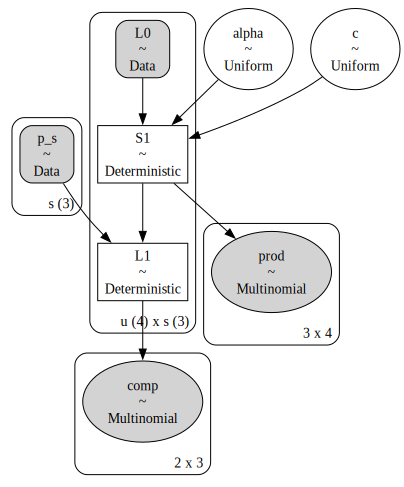

In [32]:
pm.model_to_graphviz(m_RSA_2)

In [33]:
with m_RSA_2:
    idata_2 = pm.sample(draws=10_000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, c]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7 seconds.


array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'c'}>],
      dtype=object)

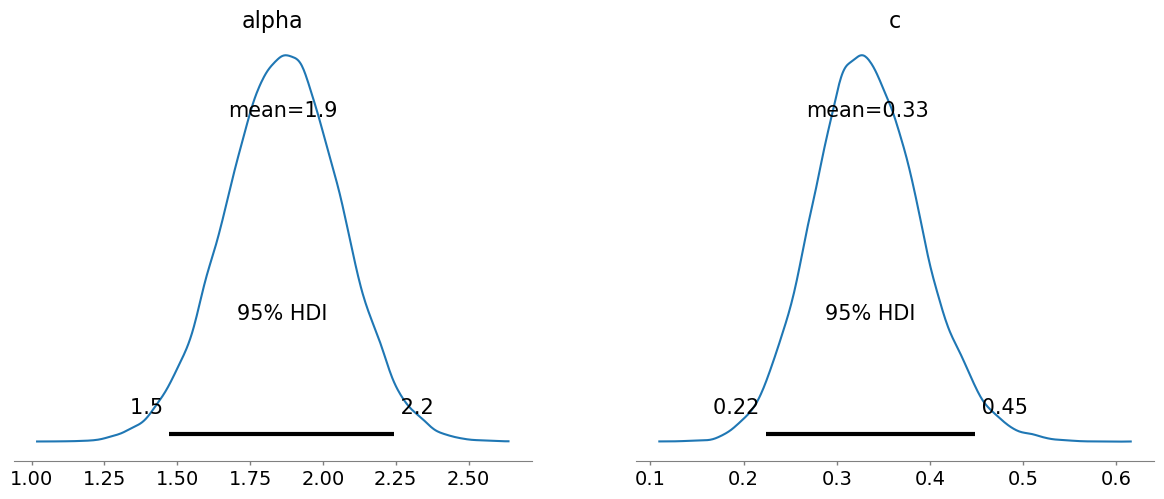

In [34]:
az.plot_posterior(idata_2, var_names=['alpha', 'c'], hdi_prob=0.95)

Model outcomes:
- the posterior for $\alpha$ has an expected value around 1.9
    - we previously showed that as $\alpha \rightarrow 0$ the pragmatic listener and the literal listener predictions are the same
    - with $\alpha \approx 1.9$ we can say that this data favors pragmatic listeners
- the posterior for $c$ has an expected value around 0.33
    - the cost was defined for color terms
    - the non-zero value for cost parameter, shows that there actually is a tendency to avoid color terms (even this effect seems small)

### Model Criticism - Posterior Predictive Checks

- We find the values which are most probable for the parameters of a model using the data-driven estimation.
- Those posterior distributions for model parameters are then interpreted with respect to the capacity that we're modeling.
- Our interpretations will be trustworthy if:
    - the model is credible (the theory we assume to generate the data)
    - data justifies the model
- In model criticism we assess the fit between data and model predictions, and revise the model if needed
- We use the model with it's parameters updated by the data: i.e. we don't assume a prior distribution, but use the poseterior distributions we obtained by parameter estimation, and sample from the outcome distribution for each possible value of the parameter set.
- In other words, to recap:
    1. We first assume a model which generates likelihood probabilities for outcomes (in this example we have a multinomial distribution that generates count observations, and RSA returns the probability values which are then used as multinomial distribution's parakmeter). In this first step we need to assume distributions (priors) for model free paramaters ($\alpha, c$)
    2. We use Bayes formula and numerical methods (e.g. MCMC) to get posterior distributions of these parameters.
    3. Now that we have informative distributions for model parameters our model predictions will be different. This new state of the model with whole distributions for parameters enables us to run the model forward to sample from the outcome distributions. This step is like simulating multiple experiments and see how probable the observed values are.

We can use probabilistic languages to sample from the posterior:

$$P(D^{rep} \mid M, D^{obs}) = \int P(\theta \mid M, D^{obs}) \cdot P(D^{rep} \mid M, \theta) \text{ d}\theta$$

where:
- $D^{rep}$: data from the replication of experiment (i.e. repeated observations)
- $M$: model that we assumed in the very beginning
- $ P(\theta \mid M, D^{obs})$: the posterior distribution that we already computed for parameters $\theta$

So, to approximate the integral given above we use each sample from the posterior distribtuion and sample a datum from the same likelihood function we assumed for the empirical dataset. Knowing the model $M$ and the parameter value $\theta$ $D^{rep}$ is sampled with probability $P(D^{rep} \mid M, \theta)$.

This computation is easy with PyMC:

In [35]:
with m_RSA_2:
    posterior_predictive = pm.sample_posterior_predictive(idata_2)

Sampling: [comp, prod]


Output()

In [36]:
idata_2.posterior

<xarray.Dataset> Size: 8MB
Dimensions:  (chain: 4, draw: 10000, u: 4, s: 3)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * u        (u) int64 32B 0 1 2 3
  * s        (s) int64 24B 0 1 2
Data variables:
    alpha    (chain, draw) float64 320kB 1.758 2.019 1.805 ... 2.184 1.942 1.942
    c        (chain, draw) float64 320kB 0.3655 0.3079 0.3871 ... 0.2817 0.2817
    S1       (chain, draw, u, s) float64 4MB 0.5651 0.2206 ... 0.7741 1.346e-08
    L1       (chain, draw, u, s) float64 4MB 0.5198 0.4802 ... 1.0 3.404e-08
Attributes:
    created_at:                 2024-12-25T20:56:32.313176+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              7.173776865005493
    tuning_steps:               2000

In [37]:
ppc = posterior_predictive.posterior_predictive.stack(samples=('chain','draw'))
ppc 

<xarray.Dataset> Size: 7MB
Dimensions:     (prod_dim_2: 3, prod_dim_3: 4, samples: 40000, comp_dim_2: 2,
                 comp_dim_3: 3)
Coordinates:
  * prod_dim_2  (prod_dim_2) int64 24B 0 1 2
  * prod_dim_3  (prod_dim_3) int64 32B 0 1 2 3
  * comp_dim_2  (comp_dim_2) int64 16B 0 1
  * comp_dim_3  (comp_dim_3) int64 24B 0 1 2
  * samples     (samples) object 320kB MultiIndex
  * chain       (samples) int64 320kB 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
  * draw        (samples) int64 320kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    prod        (prod_dim_2, prod_dim_3, samples) int64 4MB 75 97 81 ... 0 0 0
    comp        (comp_dim_2, comp_dim_3, samples) int64 2MB 86 113 ... 154 150
Attributes:
    created_at:                 2024-12-25T20:56:35.278001+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.17.0

In [38]:
speaker_ppc = ppc["prod"]
listener_ppc = ppc["comp"]

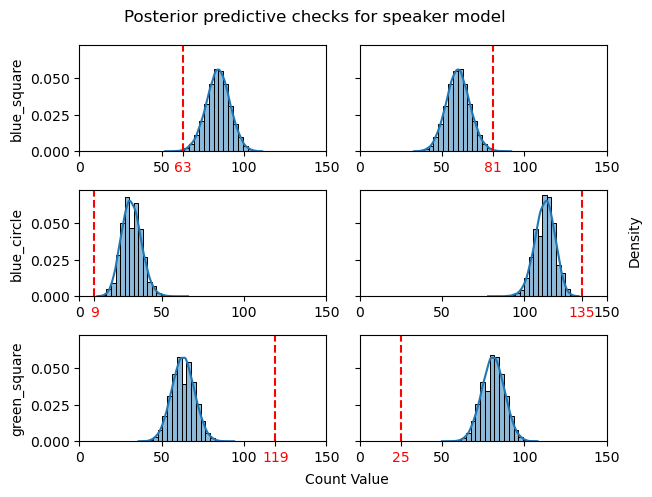

In [39]:
speaker_ppc = ppc["prod"]
listener_ppc = ppc["comp"]
fig, ax = plt.subplots(3, 2, sharey=True)
for io, o in enumerate(objects):
    color = o.split(' ')[0]
    shape = o.split(' ')[1]
    icolor = utterances.index(color)
    ishape = utterances.index(shape)
    obj_name = "_".join([color, shape])
    obs_c = prod_data[obj_name][color]
    obs_s = prod_data[obj_name][shape]
    sns.histplot(speaker_ppc[io, icolor, :].values.flatten(),
                 kde=True, ax=ax[io][0], stat="density", bins=20)
    sns.histplot(speaker_ppc[io, ishape, :].values.flatten(),
                 kde=True, ax=ax[io][1], stat="density", bins=20)
    ax[io][0].set_xlim(0, 144)
    ax[io][1].set_xlim(0, 144)
    ticks_0 = ax[io][0].get_xticks()
    ticks_1 = ax[io][1].get_xticks()
    ax[io][0].axvline(x=obs_c, linestyle='--', c='r')
    ax[io][1].axvline(x=obs_s, linestyle='--', c='r')
    ax[io][0].set_xticks(np.append(ticks_0, obs_c))
    ax[io][1].set_xticks(np.append(ticks_1, obs_s))
    for col in [0, 1]:
        for label in ax[io][col].get_xticklabels():
            if label.get_text() in [str(obs_c), str(obs_s)]:
                label.set_color("red")
    ax[io][0].set_ylabel(obj_name)

fig.text(0.55, 0, 'Count Value', ha='center', va='center')
fig.text(1, 0.5, 'Density', ha='center', va='center', rotation='vertical')

plt.suptitle("Posterior predictive checks for speaker model")
plt.tight_layout()

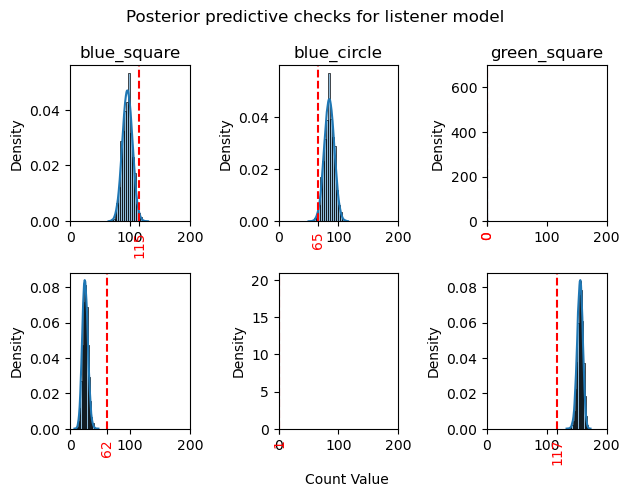

In [40]:
fig, ax = plt.subplots(2, 3)
for io, o in enumerate(objects):
    for iu, u in enumerate(["blue", "square"]):
        
        color = o.split(' ')[0]
        shape = o.split(' ')[1]
        obj_name = "_".join([color, shape])
        
        obs_data = comp_data[u][obj_name]
        
        sns.histplot(listener_ppc[iu, io, :].values.flatten(),
                    kde=True, ax=ax[iu][io], stat="density", bins=20)
        
        ax[iu][io].set_xlim(0, 180)
        ticks = ax[iu][io].get_xticks()
        
        ax[iu][io].axvline(x=obs_data, linestyle='--', c='r')
        
        ax[iu][io].set_xticks(np.append(ticks, obs_data))
        
        
        for label in ax[iu][io].get_xticklabels():
            if label.get_text() == str(obs_data):
                label.set_color("red")
                label.set_rotation(90)

        ax[0][io].set_title(obj_name)

fig.text(0.55, 0, 'Count Value', ha='center', va='center')

plt.suptitle("Posterior predictive checks for listener model")
plt.tight_layout()

What might be the problem?
- The literal listener uses a non-uniform prior, based on experimental data
- The original RSA for reference games uses a uniform one for the literal listener
- We can test this version of the model
- We'll change literal listener prior over states to be uniform
- Experimentally determined state prior will be used for the pragmatic listener

### New Model

In [41]:
with pm.Model() as m_RSA_3:
    
    # state priors from data
    p_s = pm.Data(
        'p_s',
        state_prior,
        dims=('s')
    )

    # L0 as data
    # with uniform state priors
    L0 = pm.Data(
        'L0',
        l0,
        dims=('u', 's')
    )

    # prior for alpha
    # >= 0 
    alpha = pm.Uniform(
        'alpha',
        lower=0.01,
        upper=10
    )

    # prior for cost term
    c = pm.Uniform(
        'c',
        lower=-4,
        upper=4
    )

    # P_S1(u|P_L0)
    # now with cost terms
    S1 = pm.Deterministic(
        'S1',
        normalize(
            pt.exp(
                alpha * (pt.log(L0+0.0001) - pt.reshape(pt.stack([c, c, 0, 0]), (4, 1)))
            ),
            0
        ),
        dims=('u', 's')
    )

    L1 =  pm.Deterministic(
            'L1',
            normalize(
                S1 * p_s,
                1
            ),
            dims=('u', 's')
        )
    
    # u: blue, green, square, circle
    # o: blue square, blue circle, green square

    # both S1 and L1 are shape (u, s) = (4, 3)
    
    # P(u|s)
    # we observe for each possible referent
    # counts on 4 different utterances
    # we need 4 probability values for each referent, so we take the transpose
    production = pm.Multinomial(
        "prod", n=144, p=S1.T, observed=np.array([
                                                  [63, 0, 81, 0],
                                                  [9, 0, 0, 135],
                                                  [0, 119, 25, 0]
                                                  ])
    )

    # P(s|u)
    # we observe for two utterances (blue and square)
    # counts on 3 different referents
    # we need 3 probability values for two utterances
    comprehension = pm.Multinomial(
        "comp", n=180, p=L1[[0, 2], :], observed=np.array([[115, 65, 0],
                                                           [62, 1, 117]])
    )


In [42]:
with m_RSA_3:
    idata_3 = pm.sample(draws=10_000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, c]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7 seconds.


array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'c'}>],
      dtype=object)

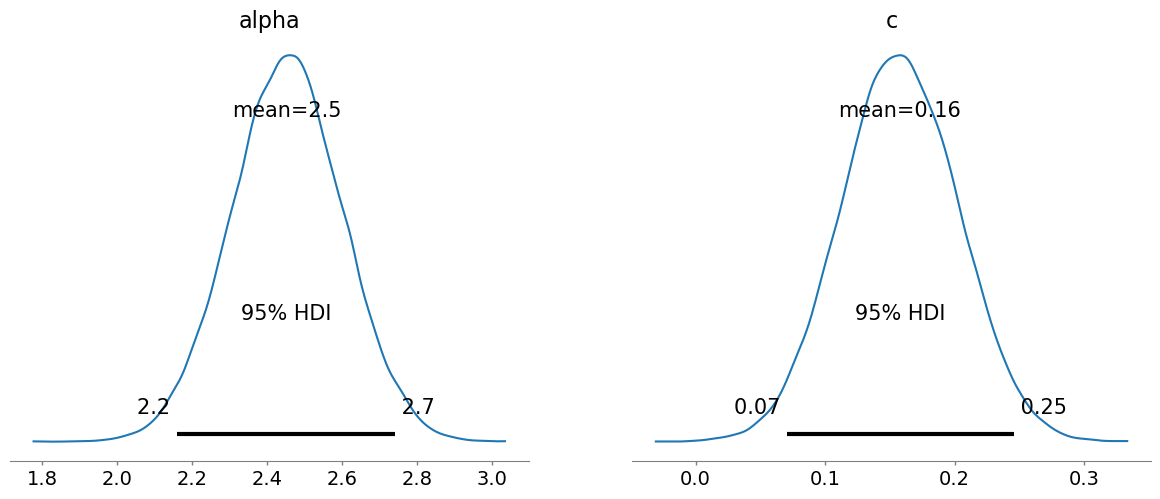

In [ ]:
with m_RSA_3:
    idata_3 = pm.sample(draws=10_000, tune=2000)
az.plot_posterior(idata_3, var_names=['alpha', 'c'], hdi_prob=0.95)

In [44]:
with m_RSA_3:
    posterior_predictive_2 = pm.sample_posterior_predictive(idata_3)

Sampling: [comp, prod]


Output()

In [45]:
ppc_2 = posterior_predictive_2.posterior_predictive.stack(samples=('chain','draw'))
speaker_ppc = ppc_2["prod"]
listener_ppc = ppc_2["comp"]

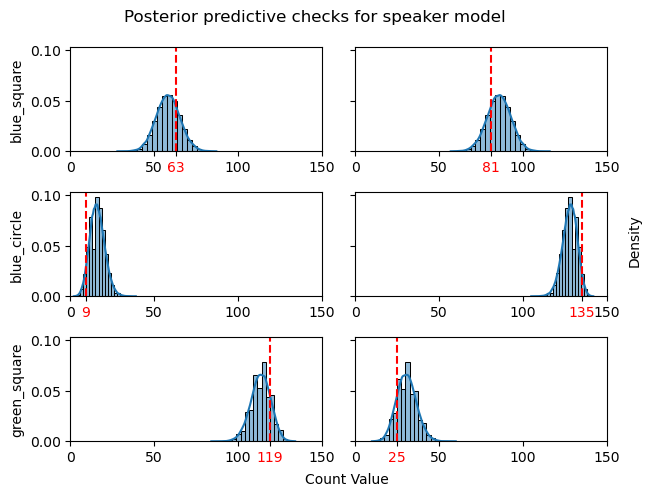

In [ ]:
ppc_2 = posterior_predictive_2.posterior_predictive.stack(samples=('chain','draw'))
speaker_ppc = ppc_2["prod"]
listener_ppc = ppc_2["comp"]
fig, ax = plt.subplots(3, 2, sharey=True)
for io, o in enumerate(objects):
    color = o.split(' ')[0]
    shape = o.split(' ')[1]
    icolor = utterances.index(color)
    ishape = utterances.index(shape)
    obj_name = "_".join([color, shape])
    obs_c = prod_data[obj_name][color]
    obs_s = prod_data[obj_name][shape]
    sns.histplot(speaker_ppc[io, icolor, :].values.flatten(),
                 kde=True, ax=ax[io][0], stat="density", bins=20)
    sns.histplot(speaker_ppc[io, ishape, :].values.flatten(),
                 kde=True, ax=ax[io][1], stat="density", bins=20)
    ax[io][0].set_xlim(0, 144)
    ax[io][1].set_xlim(0, 144)
    ticks_0 = ax[io][0].get_xticks()
    ticks_1 = ax[io][1].get_xticks()
    ax[io][0].axvline(x=obs_c, linestyle='--', c='r')
    ax[io][1].axvline(x=obs_s, linestyle='--', c='r')
    ax[io][0].set_xticks(np.append(ticks_0, obs_c))
    ax[io][1].set_xticks(np.append(ticks_1, obs_s))
    for col in [0, 1]:
        for label in ax[io][col].get_xticklabels():
            if label.get_text() in [str(obs_c), str(obs_s)]:
                label.set_color("red")
    ax[io][0].set_ylabel(obj_name)

fig.text(0.55, 0, 'Count Value', ha='center', va='center')
fig.text(1, 0.5, 'Density', ha='center', va='center', rotation='vertical')

plt.suptitle("Posterior predictive checks for speaker model")
plt.tight_layout()

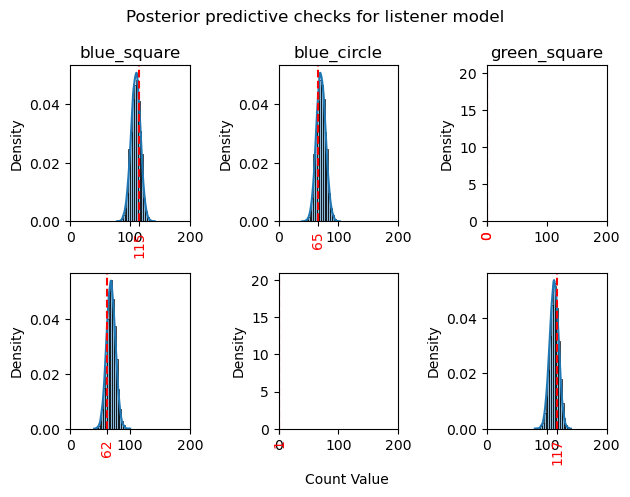

In [47]:
fig, ax = plt.subplots(2, 3)
for io, o in enumerate(objects):
    for iu, u in enumerate(["blue", "square"]):
        
        color = o.split(' ')[0]
        shape = o.split(' ')[1]
        obj_name = "_".join([color, shape])
        
        obs_data = comp_data[u][obj_name]
        
        sns.histplot(listener_ppc[iu, io, :].values.flatten(),
                    kde=True, ax=ax[iu][io], stat="density", bins=20)
        
        ax[iu][io].set_xlim(0, 180)
        ticks = ax[iu][io].get_xticks()
        
        ax[iu][io].axvline(x=obs_data, linestyle='--', c='r')
        
        ax[iu][io].set_xticks(np.append(ticks, obs_data))
        
        
        for label in ax[iu][io].get_xticklabels():
            if label.get_text() == str(obs_data):
                label.set_color("red")
                label.set_rotation(90)

        ax[0][io].set_title(obj_name)

fig.text(0.55, 0, 'Count Value', ha='center', va='center')

plt.suptitle("Posterior predictive checks for listener model")
plt.tight_layout()

### Model Comparison

- In the beginning we calculated the posterior probability for a model when we assumed that there are two models possible that could've generated the data $D$
- These models were the literal listener and pragmatic listener models. We used the Bayesian formula to get the posterior distribution as follows:
$$ P(M_{L_0} \mid D) = \frac{ P(M_{L_0}) \cdot P(D \mid M_{L_0})}{P(M_{L_0}) \cdot P(D \mid M_{L_0})  +  P(M_{L_1}) \cdot P(D \mid M_{L_1})} $$
- But there are more than two models, even some models which we don't know yet but possibly concievable.
- Even for the best model (that we know of) the data can be surprising (i.e. model can fail the posterior predictive check that we did in model criticism)
- We can't know how good a model $M$ is among all concievable models, but we can always compare two models. What we do actually is to calculate the odds ratio for two models, given data.

$$\frac{P(M_{1} \mid D)}{P(M_{2} \mid D)} = \frac{\frac{ P(M_{1}) \cdot P(D \mid M_{1})}{\cancel{P(M_{1}) \cdot P(D \mid M_{1})  +  P(M_{2}) \cdot P(D \mid M_{2})}}}{\frac{ P(M_{2}) \cdot P(D \mid M_{2})}{\cancel{P(M_{2}) \cdot P(D \mid M_{2})  +  P(M_{1}) \cdot P(D \mid M_{1})}}}$$

- Then, we're left with two odds ratio terms, and a ratio for the likelihood of data under two different models. This last term is called the Bayes factor.

$$\underbrace{\frac{P(M_1 \mid D)}{P(M_2 \mid D)}}_{\text{posterior odds}} =   \underbrace{\frac{P(M_1)}{P(M_2)}}_{\text{prior odds}} \ \underbrace{\frac{P(D \mid M_1)}{P(D \mid M_2)}}_{\text{Bayes factor}}$$

Some remarks from Franke's data analysis [course](https://michael-franke.github.io/intro-data-analysis/Chap-03-06-model-comparison-BF.html):
- The Bayes factor quantifies the strength of evidence given by the data about the models of interest
- It is the factor by which a rational agent changes her prior odds in the light of observed data to arrive at the posterior odds
- This evidence is expressed in terms of the models’ relative prior predictive accuracy
- Bayes factor is a ratio of marginal likelihoods:
$$\frac{P(D \mid M_1)}{P(D \mid M_2)} = \frac{\int P(\theta_1 \mid M_1) \ P(D \mid \theta_1, M_1) \text{ d}\theta_1}{\int P(\theta_2 \mid M_2) \ P(D \mid \theta_2, M_2) \text{ d}\theta_2}$$

There are three insights this equation provides:
1. BF is a measure of how well each model would have predicted data *ex ante*. That's why it's directly the opposite of model comparison metrics such as information criterion (e.g. AIC): they rely on the models' maximum likelihood fits (based on data, being *ex post*)
2. We declared marginal likelihoods to be hard to compute, but we now see that BF computation requires it too.
    - There are analytical solutions if priors are specified correctly
3. BF model comparison has a built-in Ocham's razor: it punishes model complexity. It not just counts free parameters but also punishes uninformativity.
    - "Since Bayes factors are computed based on ex ante predictions, a diffuse model is punished for its imprecision of prior predictions because we integrate over all parameters (weighted by priors) and their associated likelihood."

Similarly, computing Bayes factors involves marginal likelihood computation, for each model:
$$P(D \mid M_i) = \int P(\theta \mid M_i) \ P(D \mid \theta, M_i) \ \text{d}\theta$$

This integral is possible to approximate: (naive Monte Carlo)
- get samples from the prior repeatedly
- compute the likelihood of data for each sample
- take the average

$$P(D \mid M_i) \approx \frac{1}{n} \sum^{n}_{\theta_j \sim P(\theta \mid M_i)} P(D \mid \theta_j, M_i)$$

There are several possible methods to compute the Bayes factor:
- Analytical (not available for most models)
- Sequential Monte Carlo
- Savage-Dickey ratio (applicable when one model is nested within the other)
- Latent-mixture modeling (hierarchical modeling with indicator parameter)

The magnitude of BF is subject to various interpretations e.g. Jeffreys, 1961 ranks them as below. "[B]ut [these] should only be considered an approximate descriptive articulation of different standards of evidence" (Lee, 2014).
- $BF=1$: no evidence
- $1-3$: anectodal evidence
- $3-10$: moderate evidence
- $10-30$: strong evidence
- $30-100$: very strong evidence
- $BF>100$: extreme evidence in favor of $M_1$

#### Naive Monte Carlo

In [130]:
with pm.Model() as naive_MC:

    # state priors from data
    p_s = pm.Data("p_s", state_prior, dims=("s"))

    # L0 as data
    # with uniform state priors
    L0_uniform = pm.Data("L0_uniform", l0, dims=("u", "s"))
    # with experimentally-determined state priors
    L0_salience = pm.Data("L0_empirical", l0_2, dims=("u", "s"))

    # prior for alpha
    # >= 0
    alpha = pm.Uniform("alpha", lower=0.01, upper=10)

    # prior for cost term
    c = pm.Uniform("c", lower=-4, upper=4)

    # P_S1(u|P_L0)
    S1_salience = pm.Deterministic(
        "S1_salience",
        normalize(
            pt.exp(
                alpha
                * (pt.log(L0_salience + 0.0001) - pt.reshape(pt.stack([c, c, 0, 0]), (4, 1)))
            ),
            0,
        ),
        dims=("u", "s"),
    )

    S1_uniform = pm.Deterministic(
        "S1_uniform",
        normalize(
            pt.exp(
                alpha
                * (pt.log(L0_uniform + 0.0001) - pt.reshape(pt.stack([c, c, 0, 0]), (4, 1)))
            ),
            0,
        ),
        dims=("u", "s"),
    )

    L1_salience = pm.Deterministic("L1_salience", normalize(S1_salience * p_s, 1), dims=("u", "s"))
    L1_uniform = pm.Deterministic("L1_uniform", normalize(S1_uniform * p_s, 1), dims=("u", "s"))
    
    comprehension_salience = pm.Multinomial.dist(
        n=180, p=L1_salience[[0, 2], :]
    )

    comprehension_uniform = pm.Multinomial.dist(
        n=180, p=L1_uniform[[0, 2], :]
    )

    # we observe for two utterances (blue and square)

    logp_obs_salience = pm.Deterministic("logp_salience", pm.logp(comprehension_salience, 
                                np.array([[115, 65, 0], [62, 1, 117]])))
    logp_obs_uniform = pm.Deterministic("logp_uniform", pm.logp(comprehension_uniform, 
                                np.array([[115, 65, 0], [62, 1, 117]])))
    

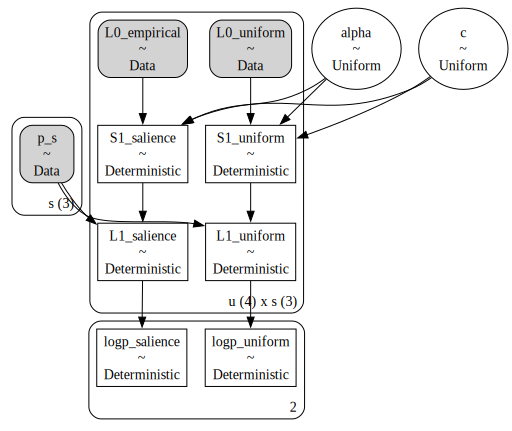

In [131]:
pm.model_to_graphviz(naive_MC)

In [132]:
with naive_MC:
    prior_predictive = pm.sample_prior_predictive(500_000)

Sampling: [alpha, c]


In [133]:
prior_predictive

Inference data with groups:
	> prior
	> constant_data

In [138]:
logp_samples_salience = prior_predictive.prior.logp_salience.stack(samples=("chain","draw"))
logp_samples_salience

<xarray.DataArray 'logp_salience' (logp_salience_dim_0: 2, samples: 500000)> Size: 8MB
array([[ -47.21275972,  -47.56281877, -246.39612449, ...,  -47.52866632,
        -335.67907748,  -47.35468913],
       [ -41.01809313, -134.84586626,  -81.59309904, ...,  -79.49132112,
         -95.79736506,  -51.2356965 ]])
Coordinates:
  * logp_salience_dim_0  (logp_salience_dim_0) int64 16B 0 1
  * samples              (samples) object 4MB MultiIndex
  * chain                (samples) int64 4MB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  * draw                 (samples) int64 4MB 0 1 2 3 ... 499997 499998 499999

In [139]:
logp_sum_salience = logp_samples_salience.sum(dim="logp_salience_dim_0")
logp_sum_salience

<xarray.DataArray 'logp_salience' (samples: 500000)> Size: 4MB
array([ -88.23085285, -182.40868503, -327.98922354, ..., -127.01998745,
       -431.47644254,  -98.59038563])
Coordinates:
  * samples  (samples) object 4MB MultiIndex
  * chain    (samples) int64 4MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (samples) int64 4MB 0 1 2 3 4 ... 499996 499997 499998 499999

In [141]:
LH_salience = np.exp(logp_sum_salience.values)
LH_salience

array([4.80648369e-039, 6.03829935e-080, 3.59823973e-143, ...,
       6.85362536e-056, 4.09413288e-188, 1.52313904e-043])

In [145]:
ML_salience = np.mean(LH_salience)
ML_salience

7.758388215266318e-16

In [146]:
logp_sum_uniform = prior_predictive.prior.logp_uniform.stack(samples=("chain","draw")).sum(dim="logp_uniform_dim_0")
LH_uniform = np.exp(logp_sum_uniform.values)
ML_uniform = np.mean(LH_uniform)
ML_uniform

9.591995709818074e-13

In [148]:
ML_uniform / ML_salience

1236.3387141344297

In [170]:
bf_list = []
for n_sample in np.arange(500, 15_000, 500):
    with naive_MC:
        pp = pm.sample_prior_predictive(n_sample)

    BF = np.mean(
        np.exp(
            pp.prior.logp_uniform.stack(samples=("chain", "draw"))
            .sum(dim="logp_uniform_dim_0")
            .values
        )
    ) / np.mean(
        np.exp(
            pp.prior.logp_salience.stack(samples=("chain", "draw"))
            .sum(dim="logp_salience_dim_0")
            .values
        )
    )

    bf_list.append(BF)

Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]
Sampling: [alpha, c]


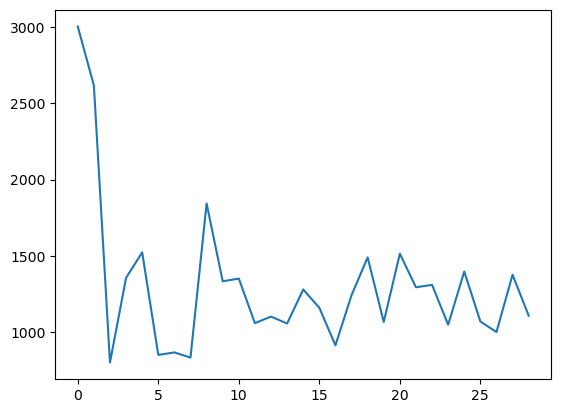

In [171]:
plt.plot(bf_list)

In [172]:
bf_list[-1]

1108.2495444877652

# References
- This chapter is a translation of WebPPL code in [problang.org](https://www.problang.org/chapters/app-04-BDA.html) Bayesian Data Analysis appendix chapter by Michael Franke
- Lee (2018) Bayesian methods in cognitive modeling, The Stevens’ handbook of experimental psychology and cognitive neuroscience.
- Lee, Wagenmakers (2014) Bayesian cognitive modeling: A practical course, Cambridge university press.
- Osvaldo Martin (2024) . "Bayes Factors and Marginal Likelihood". In: PyMC Examples. Ed. by PyMC Team. DOI: 10.5281/zenodo.5654871